### Assignment -1
#### DSCI 6650: Reinforcement Learning 
#### Master of Data Science (MDSc)
#### Name: Hashna Binte Nahar
#### ID:202290355

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

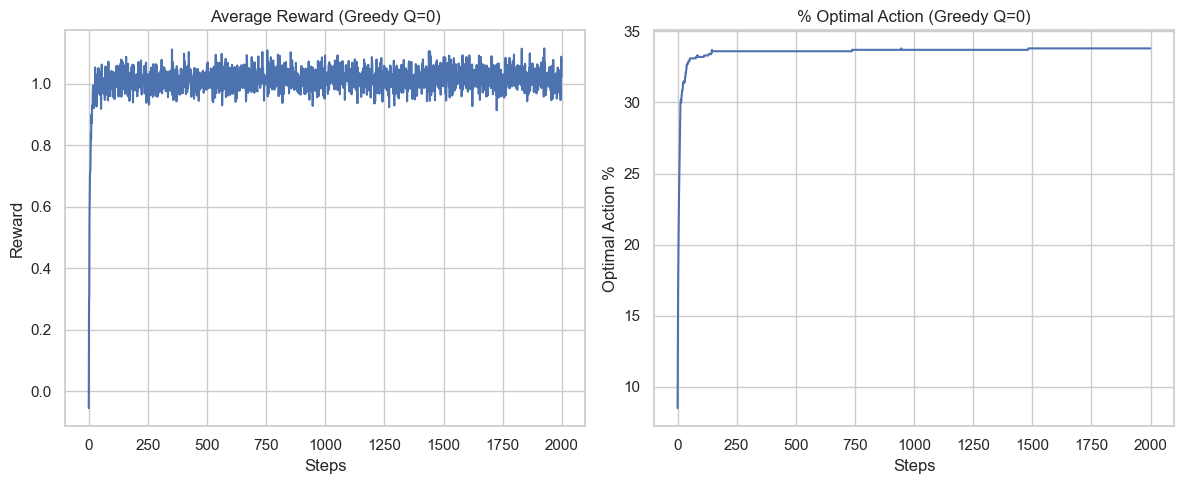

In [10]:
# Parameters
k = 10
steps = 2000
runs = 1000
np.random.seed(42)

# Generate true means
true_means_all = np.random.normal(0, 1, size=(runs, k))

# Greedy function
def greedy(true_means_all):
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps))
    for run in range(runs):
        true_means = true_means_all[run]
        Q = np.zeros(k)
        N = np.zeros(k)
        optimal_action = np.argmax(true_means)
        for t in range(steps):
            max_q = np.max(Q)
            action = np.random.choice(np.where(Q == max_q)[0])
            reward = np.random.normal(true_means[action], 1)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            rewards[run, t] = reward
            optimal[run, t] = (action == optimal_action)
    return rewards, optimal

# Run Greedy
greedy_rewards, greedy_optimal = greedy(true_means_all)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.mean(greedy_rewards, axis=0))
plt.title("Average Reward (Greedy Q=0)")
plt.xlabel("Steps")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(np.mean(greedy_optimal, axis=0) * 100)
plt.title("% Optimal Action (Greedy Q=0)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action %")

plt.tight_layout()
plt.show()


#### Epsilon-Greedy Bandit

In [12]:
#Function: Epsilon-Greedy Bandit
def epsilon_greedy(true_means_all, epsilon, steps=2000, runs=1000):
    """
    Run the epsilon-greedy algorithm on the k-armed bandit problem.

    Parameters:
        true_means_all (ndarray): Shape (runs, k) array of true mean rewards.
        epsilon (float): Probability of choosing a random action (exploration).
        steps (int): Number of time steps per simulation.
        runs (int): Number of independent simulations.

    Returns:
        avg_rewards (ndarray): Average reward at each time step (shape: [steps]).
        optimal_action_pct (ndarray): % of optimal action taken at each step (shape: [steps]).
    """
    k = true_means_all.shape[1]
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps))

    for run in range(runs):
        true_means = true_means_all[run]
        Q = np.zeros(k)             # Estimated action values
        N = np.zeros(k)             # Count of times each action has been selected
        optimal_action = np.argmax(true_means)

        for t in range(steps):
            if np.random.rand() < epsilon:
                action = np.random.randint(k)  # Explore
            else:
                action = np.random.choice(np.where(Q == np.max(Q))[0])  # Exploit

            reward = np.random.normal(true_means[action], 1)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]

            rewards[run, t] = reward
            optimal[run, t] = (action == optimal_action)

    avg_rewards = np.mean(rewards, axis=0)
    optimal_action_pct = np.mean(optimal, axis=0) * 100

    return avg_rewards, optimal_action_pct


In [13]:
import seaborn as sns

Running pilot for ε = 0.01
Running pilot for ε = 0.05
Running pilot for ε = 0.1
Running pilot for ε = 0.2
Running pilot for ε = 0.3
Running pilot for ε = 0.4


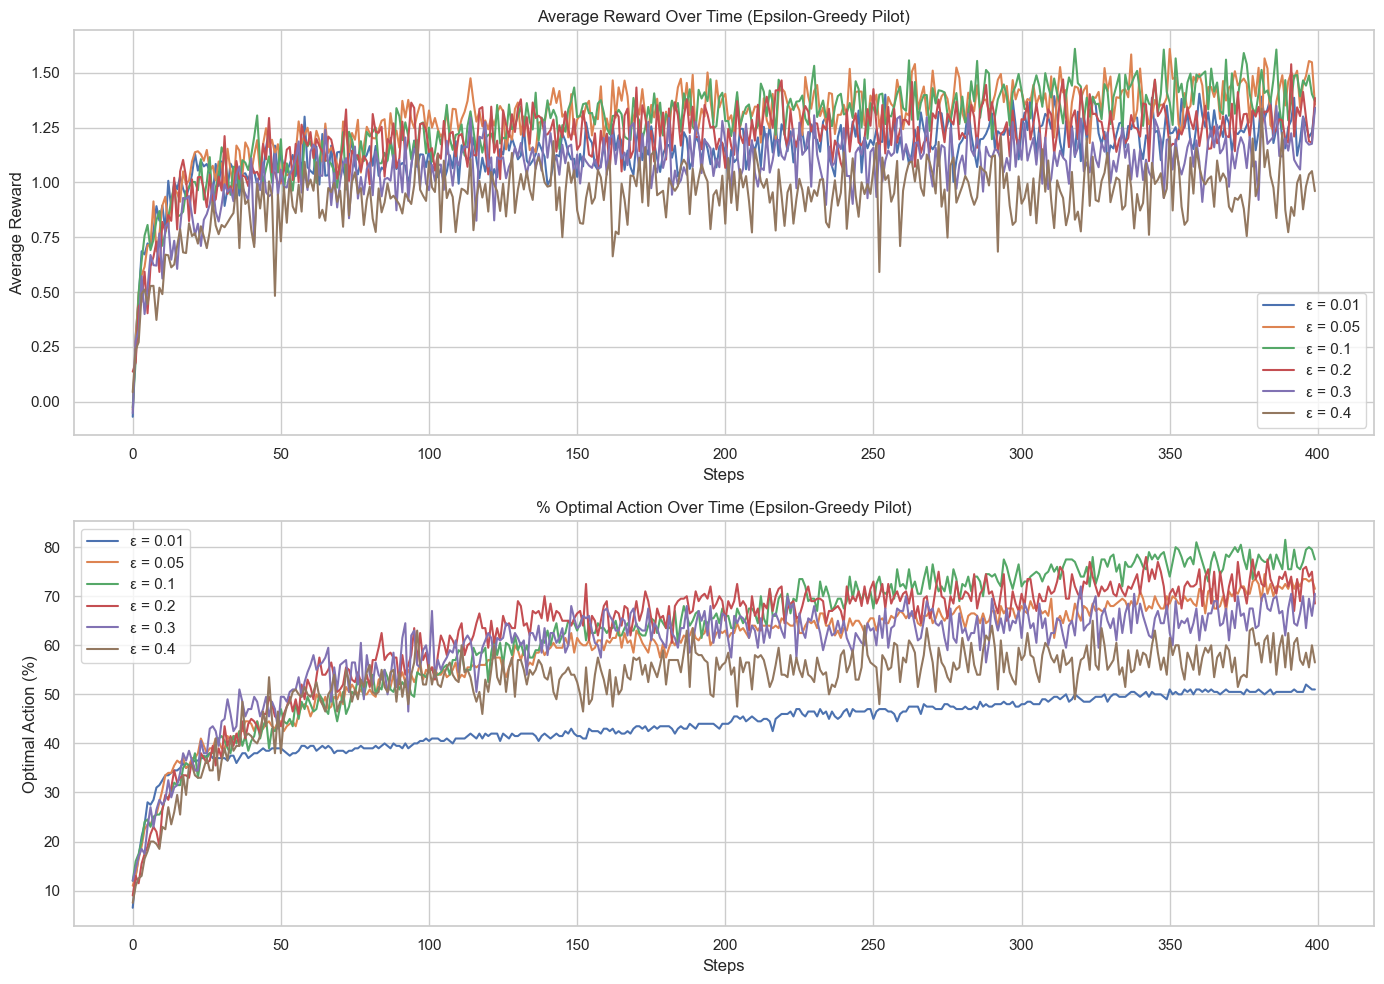

In [14]:
# --- Pilot Configuration ---
pilot_runs = 200
pilot_steps = 400
epsilon_values = [0.01,0.05, 0.1, 0.2,0.3,0.4]

# --- Generate new bandit means for the pilot run ---
np.random.seed(42)
true_means_pilot = np.random.normal(0, 1, size=(pilot_runs, k))

# --- Run Pilot for Each Epsilon ---
pilot_results = {}
for eps in epsilon_values:
    print(f"Running pilot for ε = {eps}")
    avg_r, opt_pct = epsilon_greedy(true_means_pilot, epsilon=eps, steps=pilot_steps, runs=pilot_runs)
    pilot_results[eps] = {
        'avg_rewards': avg_r,
        'optimal_pct': opt_pct
    }
# Plot – Average Rewards & % Optimal Action for Each Epsilon Greedy
# Configure plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Plot: Average Rewards
plt.subplot(2, 1, 1)
for eps in epsilon_values:
    plt.plot(pilot_results[eps]['avg_rewards'], label=f"ε = {eps}")
plt.title("Average Reward Over Time (Epsilon-Greedy Pilot)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

# Plot: % Optimal Action
plt.subplot(2, 1, 2)
for eps in epsilon_values:
    plt.plot(pilot_results[eps]['optimal_pct'], label=f"ε = {eps}")
plt.title("% Optimal Action Over Time (Epsilon-Greedy Pilot)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()

plt.tight_layout()
plt.show()

#### From epsilon we select 0.1 as it is consistance

#### Optimistic Greedy

C:\Users\Morshedul Kabir\AppData\Local\Temp\ipykernel_8788\584109730.py:58: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()


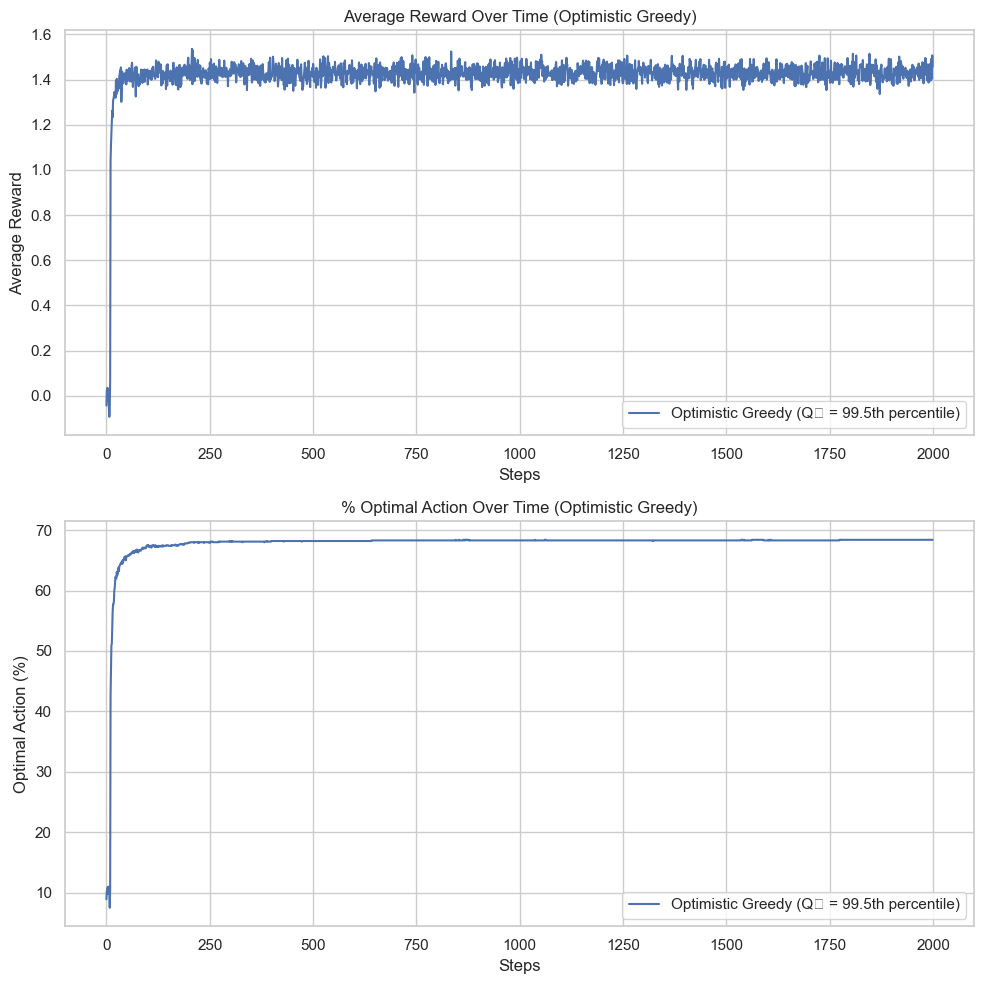

In [35]:
# Function of Optimistic Greedy
def optimistic_greedy(true_means_all, steps=2000, runs=1000):
    """
    Greedy algorithm with optimistic initialization.
    - Initial Q values are set to the 99.5th percentile of N(μ_max, 1)
    """
    k = true_means_all.shape[1]
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps))

    # Find the highest mean arm across all runs
    max_mu = np.max(true_means_all, axis=1).max()
    
    # 99.5th percentile of N(μ_max, 1)
    optimistic_init = np.percentile(np.random.normal(loc=max_mu, scale=1, size=100000), 99.5)
    op_value = optimistic_init

    for run in range(runs):
        true_means = true_means_all[run]
        Q = np.full(k, optimistic_init)  # Optimistic Q-values
        N = np.zeros(k)
        optimal_action = np.argmax(true_means)

        for t in range(steps):
            action = np.random.choice(np.where(Q == Q.max())[0])
            reward = np.random.normal(true_means[action], 1)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            rewards[run, t] = reward
            optimal[run, t] = (action == optimal_action)

    avg_rewards = np.mean(rewards, axis=0)
    optimal_action_pct = np.mean(optimal, axis=0) * 100
    return avg_rewards, optimal_action_pct
#Run the function
avg_rewards_optimistic, opt_action_pct_optimistic = optimistic_greedy(true_means_all, steps=steps, runs=runs)

# Now plot the result
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))  # Taller figure for vertical layout

# Plot: Average Reward
plt.subplot(2, 1, 1)
plt.plot(avg_rewards_optimistic, label="Optimistic Greedy (Q₀ = 99.5th percentile)")
plt.title("Average Reward Over Time (Optimistic Greedy)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

# Plot: % Optimal Action
plt.subplot(2, 1, 2)
plt.plot(opt_action_pct_optimistic, label="Optimistic Greedy (Q₀ = 99.5th percentile)")
plt.title("% Optimal Action Over Time (Optimistic Greedy)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()

plt.tight_layout()
plt.show()

#### Gradient bandit algorithm

##### Try different learning rates α and determine a good one through some pilot runs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Gradient Bandit Function 

In [6]:
# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Gradient Bandit Algorithm
def gradient_bandit(true_means_all, alpha, steps=2000, runs=1000):
    """
    Gradient bandit implementation with baseline.
    
    Parameters:
        true_means_all (ndarray): Shape (runs, k) - bandit reward means.
        alpha (float): Learning rate for gradient ascent.
        steps (int): Number of time steps.
        runs (int): Number of independent simulations.
    
    Returns:
        avg_rewards (ndarray): Average rewards over time.
        optimal_action_pct (ndarray): % optimal action over time.
    """
    k = true_means_all.shape[1]
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps))

    for run in range(runs):
        true_means = true_means_all[run]
        optimal_action = np.argmax(true_means)

        H = np.zeros(k)         # Preference values
        pi = softmax(H)         # Action probabilities
        avg_reward = 0

        for t in range(steps):
            action = np.random.choice(k, p=pi)
            reward = np.random.normal(true_means[action], 1)

            avg_reward += (reward - avg_reward) / (t + 1)
            one_hot = np.zeros(k)
            one_hot[action] = 1

            # Gradient ascent update with baseline
            H += alpha * (reward - avg_reward) * (one_hot - pi)
            pi = softmax(H)

            rewards[run, t] = reward
            optimal[run, t] = (action == optimal_action)

    avg_rewards = np.mean(rewards, axis=0)
    optimal_action_pct = np.mean(optimal, axis=0) * 100

    return avg_rewards, optimal_action_pct


####  Run Pilot for Different α (with plotting)

Running pilot for α = 0.1
Average reward: 1.2247168129397392
Average action percentage: 6355.875
Running pilot for α = 0.2
Average reward: 1.341916354068959
Average action percentage: 6713.375000000001
Running pilot for α = 0.4
Average reward: 1.359059265909521
Average action percentage: 6130.625
Running pilot for α = 0.6
Average reward: 1.3615621572254926
Average action percentage: 6291.625
Running pilot for α = 0.8
Average reward: 1.361677961649853
Average action percentage: 6465.875
Running pilot for α = 1.0
Average reward: 1.2294252852961058
Average action percentage: 5124.125


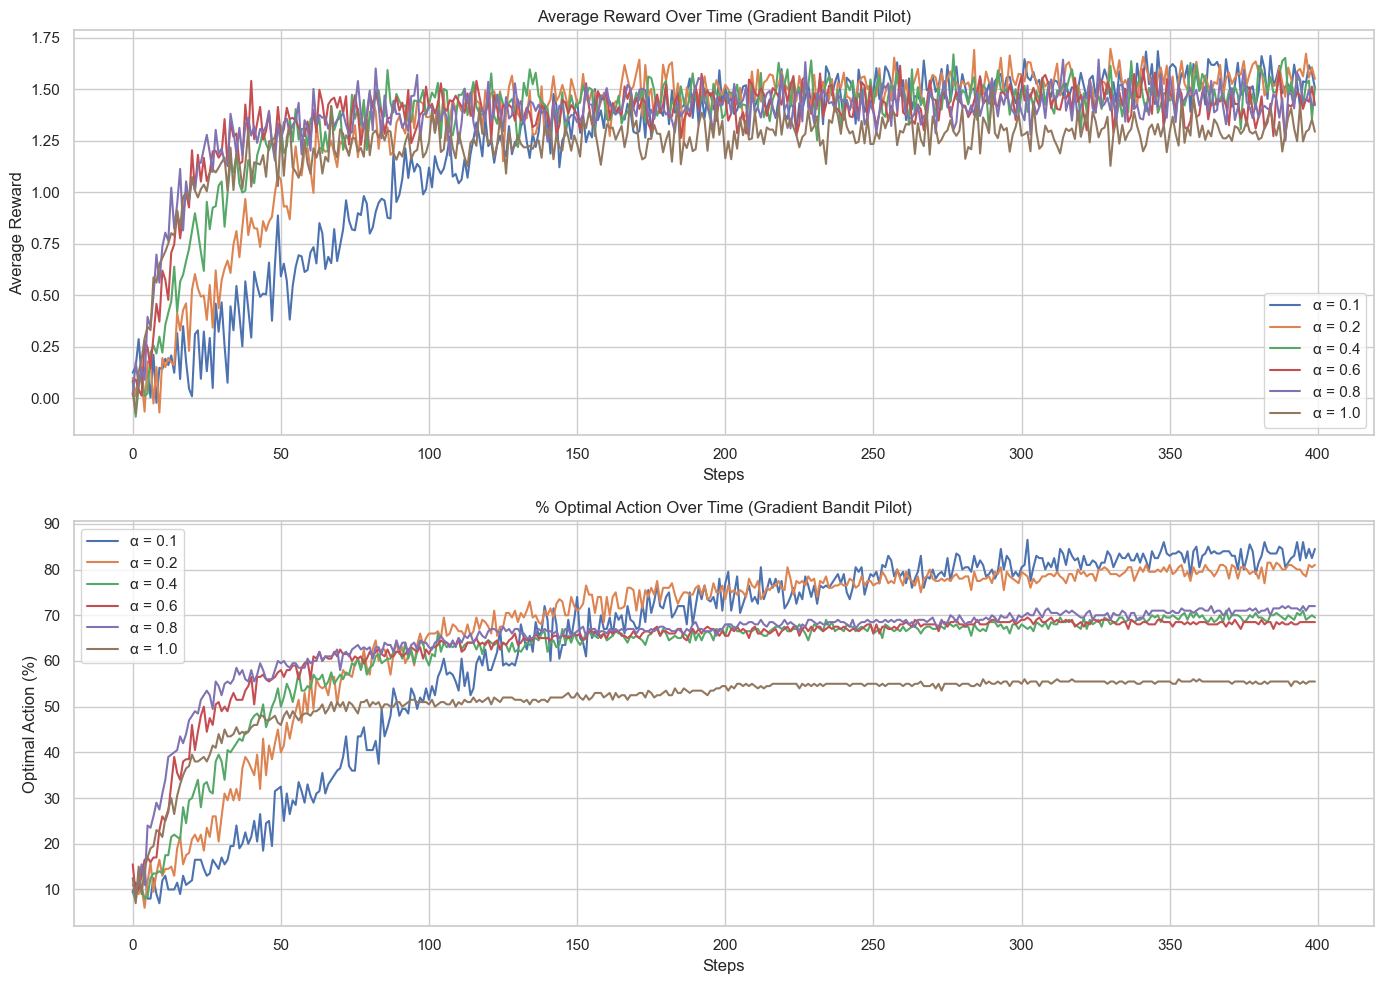

In [8]:

# Set reproducible seed and experiment config
np.random.seed(42)
k = 10
pilot_steps = 400
pilot_runs = 200
alphas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
true_means_pilot = np.random.normal(0, 1, size=(pilot_runs, k))

# Run pilot
pilot_results = {}
for alpha in alphas:
    print(f"Running pilot for α = {alpha}")
    avg_r, opt_pct = gradient_bandit(true_means_pilot, alpha=alpha, steps=pilot_steps, runs=pilot_runs)
    opt_pct_overall= opt_pct.mean() * 100
    
    avg_rewards = avg_r.mean(axis=0)
    overall_avg = avg_rewards.mean()
    
    print ( "Average reward:", overall_avg)
    print ( "Average action percentage:", opt_pct_overall)
    pilot_results[alpha] = {
        'avg_rewards': avg_r,
        'optimal_pct': opt_pct
    }

# Plot results
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Plot 1: Average Reward
plt.subplot(2, 1, 1)
for alpha in alphas:
    plt.plot(pilot_results[alpha]['avg_rewards'], label=f"α = {alpha}")
plt.title("Average Reward Over Time (Gradient Bandit Pilot)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

# Plot 2: % Optimal Action
plt.subplot(2, 1, 2)
for alpha in alphas:
    plt.plot(pilot_results[alpha]['optimal_pct'], label=f"α = {alpha}")
plt.title("% Optimal Action Over Time (Gradient Bandit Pilot)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()

plt.tight_layout()
plt.show()


#####  Based on the average reward and optimal action percentage curves, we found that α = 0.2  provides a good balance between exploration and convergence, with stable and efficient learning curves.

#### Final Comparison Code

Running final simulations for comparison...


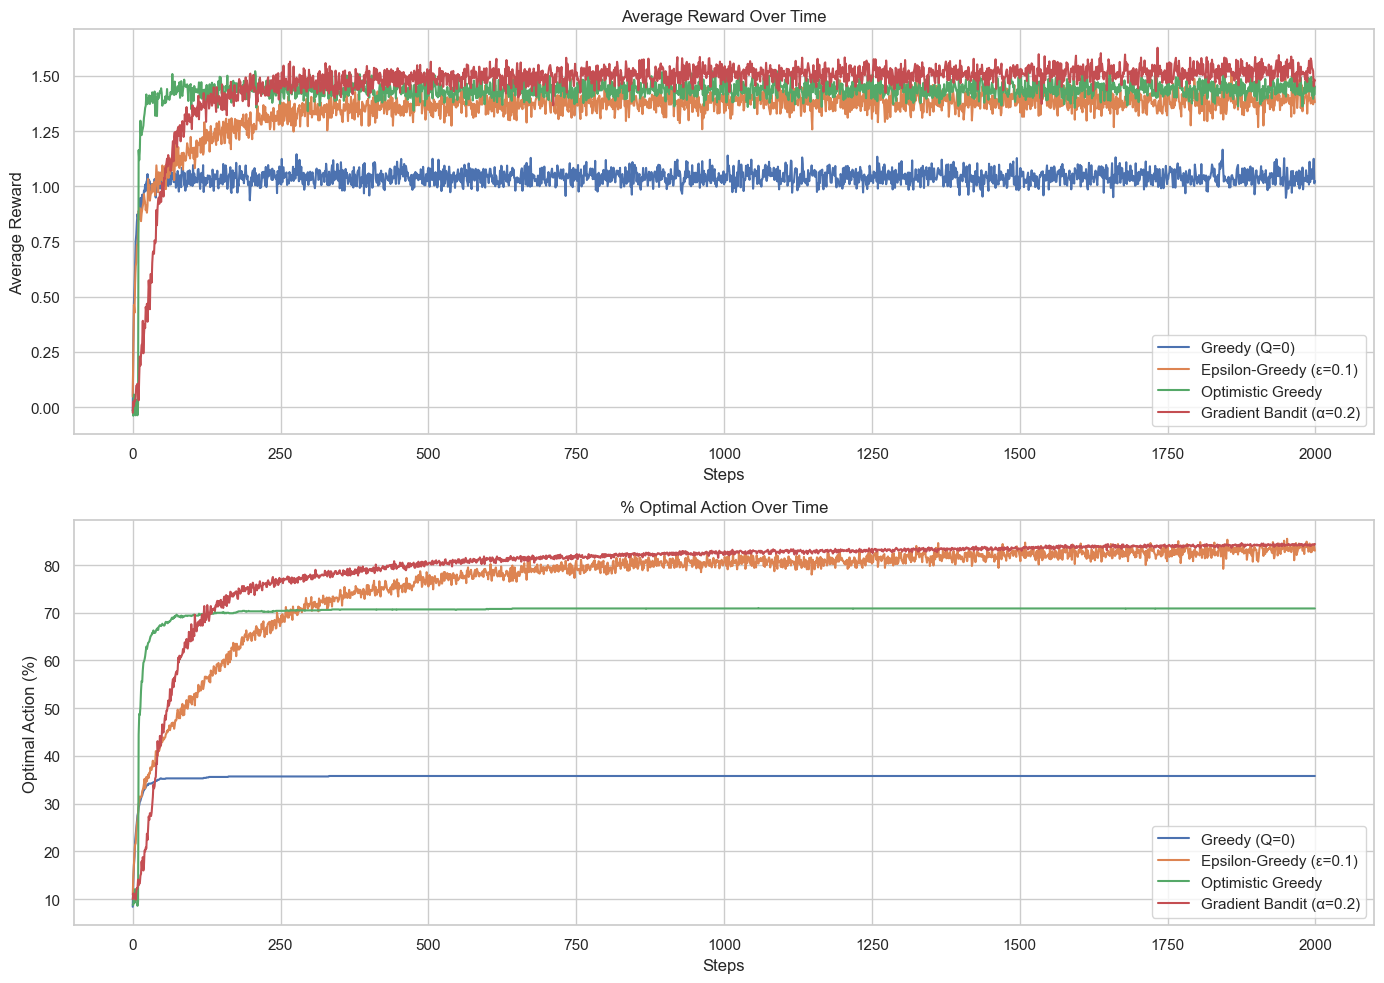

In [31]:
# Final Comparison for All Four Methods (1000 simulations, 2000 steps)
# Using already defined functions and true_means_all

# Run the final experiments
print("Running final simulations for comparison...")

greedy_rewards, greedy_optimal = greedy(true_means_all)
egreedy_rewards, egreedy_optimal = epsilon_greedy(true_means_all, epsilon=0.1)
optim_rewards, optim_optimal = optimistic_greedy(true_means_all, steps=steps, runs=runs)
grad_rewards, grad_optimal = gradient_bandit(true_means_all, alpha=0.2, steps=steps, runs=runs)

# Plot the comparison
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# --- Plot: Average Rewards ---
plt.subplot(2, 1, 1)
plt.plot(np.mean(greedy_rewards, axis=0), label="Greedy (Q=0)")
plt.plot(egreedy_rewards, label="Epsilon-Greedy (ε=0.1)")
plt.plot(optim_rewards, label="Optimistic Greedy")
plt.plot(grad_rewards, label="Gradient Bandit (α=0.2)")
plt.title("Average Reward Over Time")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

# --- Plot: % Optimal Action ---
plt.subplot(2, 1, 2)
plt.plot(np.mean(greedy_optimal, axis=0) * 100, label="Greedy (Q=0)")
plt.plot(egreedy_optimal, label="Epsilon-Greedy (ε=0.1)")
plt.plot(optim_optimal, label="Optimistic Greedy")
plt.plot(grad_optimal, label="Gradient Bandit (α=0.2)")
plt.title("% Optimal Action Over Time")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()

plt.tight_layout()
plt.show()


##### We assessed the four bandit algorithms using two measures following 1000 simulations and 2000 steps on a reliable k-armed testbed: 1. The mean reward for each time step  2. The proportion of time that the best course of action was followed
##### The best-performing strategies, as determined by optimal action percentage and average reward, were: Gradient Bandit (α = 0.2) and Epsilon-Greedy (ε = 0.1)
##### By rapidly locating and taking advantage of the best arm while preserving some degree of exploration, these two strategies routinely beat others.
#### Why the Best Techniques Are Effective
##### Epsilon-Greedy is effective because it keeps the agent from being trapped on early poor estimates by guaranteeing exploration throughout.
##### Gradient Bandit may make fine-tuning decisions over time while adjusting to reward distributions by dynamically modifying preferences based on the reward baseline.

### 2 Part 2

### Class Definition: Non Stationary Bandit Environment

This class defines a non-stationary k-armed bandit environment that supports:
**Drift** (random walk in means)
**Mean-Reverting** dynamics (e.g., reverting to zero)
**Abrupt Changes** via permutation at a fixed time (e.g., `t = 501`)
Optional **Hard Reset** of agent estimates after abrupt change

Used to simulate realistic dynamic environments for evaluating different action-selection algorithms.


In [18]:
SEEDS = np.random.RandomState(42).randint(0, 100000, 1000)

class NonstationaryBandit:
    def __init__(self, k=10, steps=steps, drift_std=0.01, mean_reverting=False, abrupt_change=False, hard_reset=False):
        self.k = k
        self.steps = steps
        self.drift_std = drift_std
        self.mean_reverting = mean_reverting
        self.abrupt_change = abrupt_change
        self.hard_reset = hard_reset
        self.kappa = 0.5
        self.reset()

    def reset(self):
        self.means = np.random.normal(0, 1, self.k)
        self.initial_means = self.means.copy()
        self.mean_history = [self.means.copy()]

    def update_means(self):
        noise = np.random.normal(0, self.drift_std, self.k)
        if self.mean_reverting:
            self.means = self.kappa * self.means + noise
        else:
            self.means += noise
        self.mean_history.append(self.means.copy())

    def permute_means(self):
        np.random.seed(42)
        self.means = self.means[np.random.permutation(self.k)]

    def get_reward(self, action):
        return np.random.normal(self.means[action], 1)

    def get_optimal_action(self):
        return np.argmax(self.means)


##### Execution

### Function: `run_algorithm()` – Execute Action-Selection Strategies

This function simulates the interaction between a learning algorithm and the `NonstationaryBandit` environment. It supports:
- **Greedy**
- **Epsilon-Greedy**
- **Optimistic Greedy**
- **Gradient Bandit (with baseline)**
#### Key Features:
- Adapts to drift, mean-reversion, and abrupt changes (e.g., permuting means at step `t = 501`)
- Supports **hard reset** for abrupt change scenarios
- Updates action-value estimates or preferences accordingly
#### Returns:
- `avg_rewards`: Reward at each time step
- `optimal_action_taken`: Binary array indicating whether the optimal action was selected


In [19]:
def run_algorithm(bandit, algorithm, alpha=None, epsilon=None, optimistic_value=None):
    Q = np.zeros(bandit.k) if optimistic_value is None else np.ones(bandit.k) * optimistic_value
    H = np.zeros(bandit.k)
    action_counts = np.zeros(bandit.k)
    avg_rewards = []
    optimal_action_taken = []
    probs = np.ones(bandit.k) / bandit.k
    baseline = 0

    for t in range(bandit.steps):
        if bandit.abrupt_change and t == 501:
            bandit.permute_means()
            if bandit.hard_reset:
                Q = np.zeros(bandit.k)
                H = np.zeros(bandit.k)
                action_counts = np.zeros(bandit.k)
                baseline = 0

        if algorithm == "greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "epsilon-greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(bandit.k)
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "optimistic-greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "gradient-bandit":
            exp_prefs = np.exp(H - np.max(H))
            probs = exp_prefs / np.sum(exp_prefs)
            action = np.random.choice(bandit.k, p=probs)

        reward = bandit.get_reward(action)
        optimal = bandit.get_optimal_action()
        avg_rewards.append(reward)
        optimal_action_taken.append(1 if action == optimal else 0)

        action_counts[action] += 1
        if algorithm == "gradient-bandit":
            baseline += (reward - baseline) / (t + 1)
            for a in range(bandit.k):
                if a == action:
                    H[a] += alpha * (reward - baseline) * (1 - probs[a])
                else:
                    H[a] -= alpha * (reward - baseline) * probs[a]
        else:
            Q[action] += (reward - Q[action]) / action_counts[action]

    return avg_rewards, optimal_action_taken


### Evaluate Algorithms Over Multiple Random Seeds

This function runs a complete simulation of a specified action-selection algorithm across 1000 independent random seeds using the non stationary bandit environment.
#### Key Features:
- Supports simulation under different **non-stationary conditions**:
  - `drift`: Gradual random walk in reward means
  - `mean_revert`: Reward means tend to revert to 0 over time
  - `abrupt`: Sudden permutation of means at time step 501
  - `reset`: Optional hard reset of algorithm estimates at the changepoint
#### Returns:
- `avg_rewards`: Average reward at each time step across 1000 runs
- `optimal_action_probs`: Percentage of optimal action selected over time


In [20]:
def simulate(method, alpha=None, epsilon=None, optimistic_value=None, drift=True, mean_revert=False, abrupt=False, reset=False):
    avg_rewards = np.zeros(2000)
    optimal_action_probs = np.zeros(2000)
    seeds=SEEDS

    for s in tqdm(seeds):
        np.random.seed(s)
        bandit = NonstationaryBandit(
            drift_std=0.01,
            mean_reverting=mean_revert,
            abrupt_change=abrupt,
            hard_reset=reset
        )
        r, o = run_algorithm(bandit, method, alpha=alpha, epsilon=epsilon, optimistic_value=optimistic_value)
        avg_rewards += r
        optimal_action_probs += o

    avg_rewards /= 1000
    optimal_action_probs /= 1000
    return avg_rewards, optimal_action_probs

### Visual Comparison of Algorithm Performance

This function creates overlay plots to visualize and compare:
- **Average reward** over time, and
- **Percentage of optimal actions** taken
#### Used in both **stationary** and **non-stationary** simulation comparisons.


In [21]:
def plot_results(results, title):
    plt.figure(figsize=(12, 5))
    for label, (rewards, _) in results.items():
        plt.plot(rewards, label=f"{label} (Reward)")
    plt.title(f"Average Reward - {title}")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 5))
    for label, (_, opt_probs) in results.items():
        plt.plot(opt_probs, label=f"{label} (% Optimal)")
    plt.title(f"% Optimal Action - {title}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.grid()
    plt.show()

### Tuning ε in Non-Stationary Settings


In [22]:
def pilot_epsilon_nonstationary(env_type, smooth_window=50):
    epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
    pilot_runs = 200
    pilot_steps = 500
    plt.figure(figsize=(12, 10))

    print(f"=== Avg Reward per ε ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 1)
    for eps in epsilons:
        rewards = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            r, _ = run_algorithm(bandit, "epsilon-greedy", epsilon=eps)
            rewards.append(r[:pilot_steps])
        rewards = np.array(rewards)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"ε = {eps:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(np.mean(rewards, axis=0), label=f"ε = {eps}")
    plt.title(f"Epsilon-Greedy Avg Reward - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("Avg Reward")
    plt.legend()

    print(f"\n=== % Optimal Action per ε ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 2)
    for eps in epsilons:
        opts = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            _, o = run_algorithm(bandit, "epsilon-greedy", epsilon=eps)
            opts.append(o[:pilot_steps])
        opts = np.array(opts)
        avg_opt = opts.mean(axis=0)
        overall_opt = avg_opt.mean() * 100
        smoothed_opt = avg_opt[-smooth_window:].mean() * 100
        print(f"ε = {eps:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(np.mean(opts, axis=0), label=f"ε = {eps}")
    plt.title(f"Epsilon-Greedy % Optimal - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Tuning α in Non-Stationary Environments
####  Purpose:
To identify the most stable and high-performing α value for use in full simulations under dynamic conditions.


In [23]:
def pilot_gradient_nonstationary(env_type, smooth_window=50):
    alphas = [0.01, 0.05, 0.1, 0.2]
    pilot_runs = 200
    pilot_steps = 500
    plt.figure(figsize=(20, 10))

    print(f"=== Avg Reward per α ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 1)
    for alpha in alphas:
        rewards = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            r, _ = run_algorithm(bandit, "gradient-bandit", alpha=alpha)
            rewards.append(r[:pilot_steps])
        rewards = np.array(rewards)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"α = {alpha:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(np.mean(rewards, axis=0), label=f"α = {alpha}")
    plt.title(f"Gradient Bandit Avg Reward - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("Avg Reward")
    plt.legend()

    print(f"\n=== % Optimal Action per α ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 2)
    for alpha in alphas:
        opts = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            _, o = run_algorithm(bandit, "gradient-bandit", alpha=alpha)
            opts.append(o[:pilot_steps])
        opts = np.array(opts)
        avg_opt = opts.mean(axis=0)
        overall_opt = avg_opt.mean() * 100
        smoothed_opt = avg_opt[-smooth_window:].mean() * 100
        print(f"α = {alpha:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(np.mean(opts, axis=0), label=f"α = {alpha}")
    plt.title(f"Gradient Bandit % Optimal - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Pilot Studies for Non-Stationary Environments (Epsilon-Greedy and Gradient Bandit)

This section conducts **pilot studies** to tune hyperparameters for the following algorithms under three types of non-stationary reward environments:

- **Drift**: Rewards drift gradually over time (`μₜ = μₜ₋₁ + εₜ`).
- **Mean-Reverting**: Rewards tend to stabilize towards zero (`μₜ = κμₜ₋₁ + εₜ`, with κ < 1).
- **Abrupt**: Rewards abruptly change at time step *t = 501* by permuting means.

#### Goal:
- Identify the best ε (exploration rate) for **epsilon-greedy**.
- Identify the best α (learning rate) for **gradient bandit**.

##### Here Each study:
- Runs 200 simulations over 500 steps.
- Displays average rewards and % optimal actions.
- Helps choose robust parameters for final non-stationary evaluations.


Running pilot study for epsilon-greedy...
=== Avg Reward per ε (Drift Environment) ===
ε = 0.01 -> Overall Avg = 1.0416, Last 50 Avg = 1.1337
ε = 0.05 -> Overall Avg = 1.4013, Last 50 Avg = 1.5593
ε = 0.10 -> Overall Avg = 1.2022, Last 50 Avg = 1.2884
ε = 0.20 -> Overall Avg = 1.1153, Last 50 Avg = 1.1948
ε = 0.30 -> Overall Avg = 0.9809, Last 50 Avg = 1.0366

=== % Optimal Action per ε (Drift Environment) ===
ε = 0.01 -> Overall Optimal = 43.80%, Last 50 = 49.05%
ε = 0.05 -> Overall Optimal = 56.97%, Last 50 = 74.47%
ε = 0.10 -> Overall Optimal = 62.62%, Last 50 = 74.91%
ε = 0.20 -> Overall Optimal = 62.80%, Last 50 = 70.75%
ε = 0.30 -> Overall Optimal = 57.75%, Last 50 = 65.69%


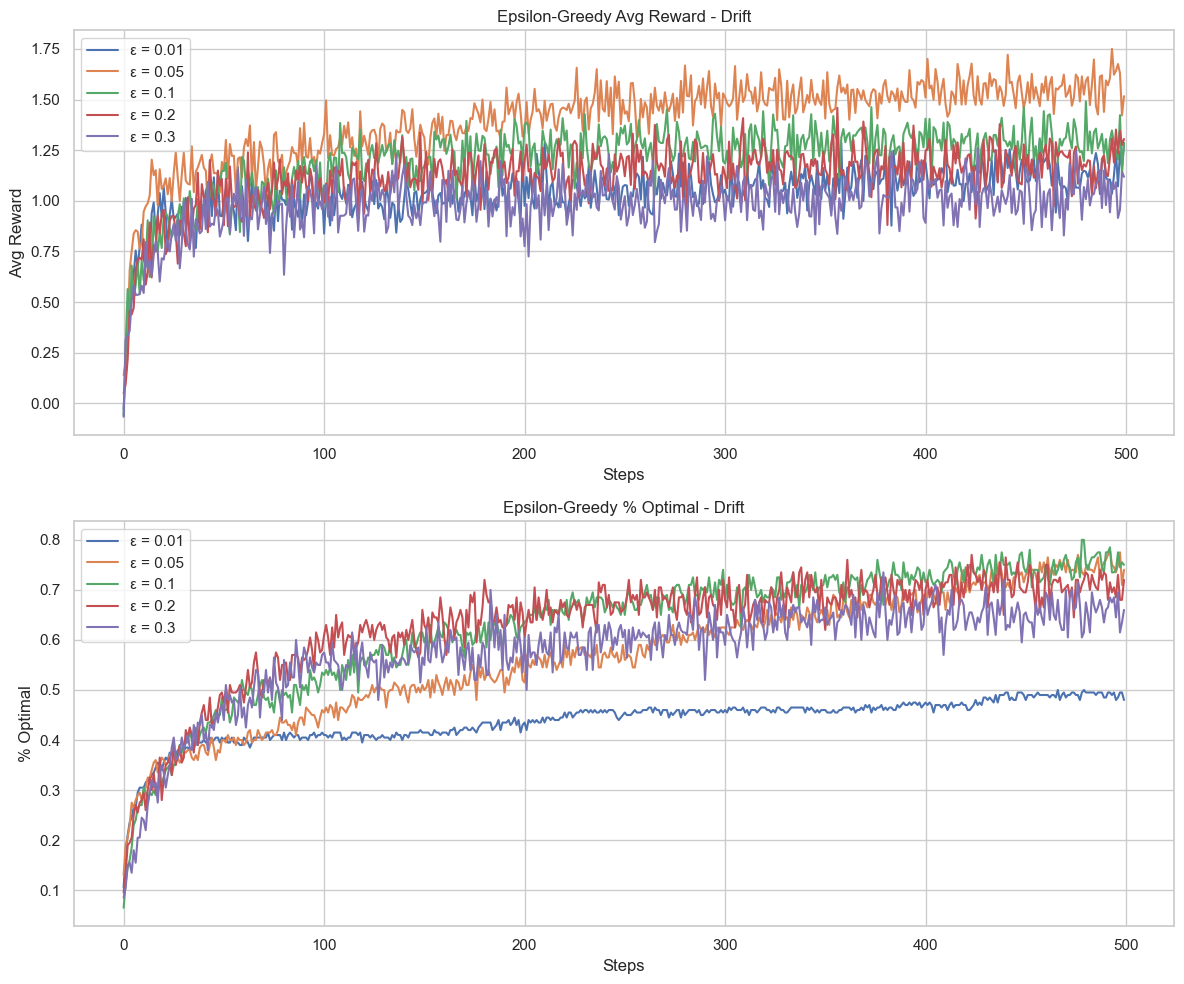

=== Avg Reward per ε (Mean Environment) ===
ε = 0.01 -> Overall Avg = 1.0951, Last 50 Avg = 1.1777
ε = 0.05 -> Overall Avg = 1.3020, Last 50 Avg = 1.4329
ε = 0.10 -> Overall Avg = 1.2704, Last 50 Avg = 1.3660
ε = 0.20 -> Overall Avg = 1.1178, Last 50 Avg = 1.1651
ε = 0.30 -> Overall Avg = 1.0603, Last 50 Avg = 1.1015

=== % Optimal Action per ε (Mean Environment) ===
ε = 0.01 -> Overall Optimal = 46.10%, Last 50 = 51.87%
ε = 0.05 -> Overall Optimal = 63.58%, Last 50 = 74.26%
ε = 0.10 -> Overall Optimal = 61.69%, Last 50 = 74.80%
ε = 0.20 -> Overall Optimal = 61.58%, Last 50 = 68.97%
ε = 0.30 -> Overall Optimal = 59.09%, Last 50 = 67.17%


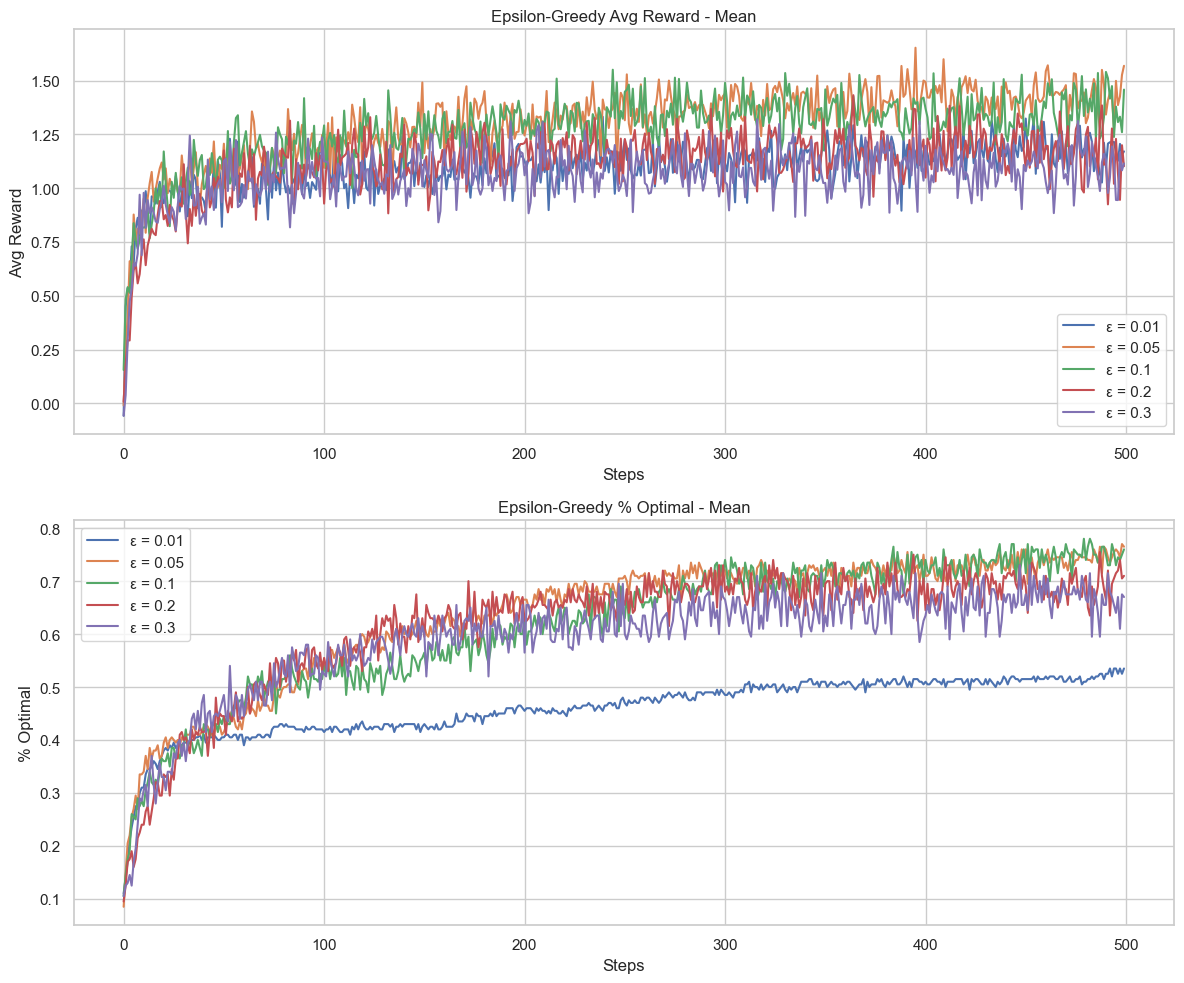

=== Avg Reward per ε (Abrupt Environment) ===
ε = 0.01 -> Overall Avg = 1.4147, Last 50 Avg = 1.4357
ε = 0.05 -> Overall Avg = 1.0476, Last 50 Avg = 1.1500
ε = 0.10 -> Overall Avg = 1.1594, Last 50 Avg = 1.3788
ε = 0.20 -> Overall Avg = 1.3919, Last 50 Avg = 1.5978
ε = 0.30 -> Overall Avg = 0.7039, Last 50 Avg = 0.5688

=== % Optimal Action per ε (Abrupt Environment) ===
ε = 0.01 -> Overall Optimal = 99.19%, Last 50 = 100.00%
ε = 0.05 -> Overall Optimal = 45.85%, Last 50 = 97.98%
ε = 0.10 -> Overall Optimal = 64.87%, Last 50 = 87.58%
ε = 0.20 -> Overall Optimal = 31.79%, Last 50 = 82.03%
ε = 0.30 -> Overall Optimal = 70.69%, Last 50 = 75.97%


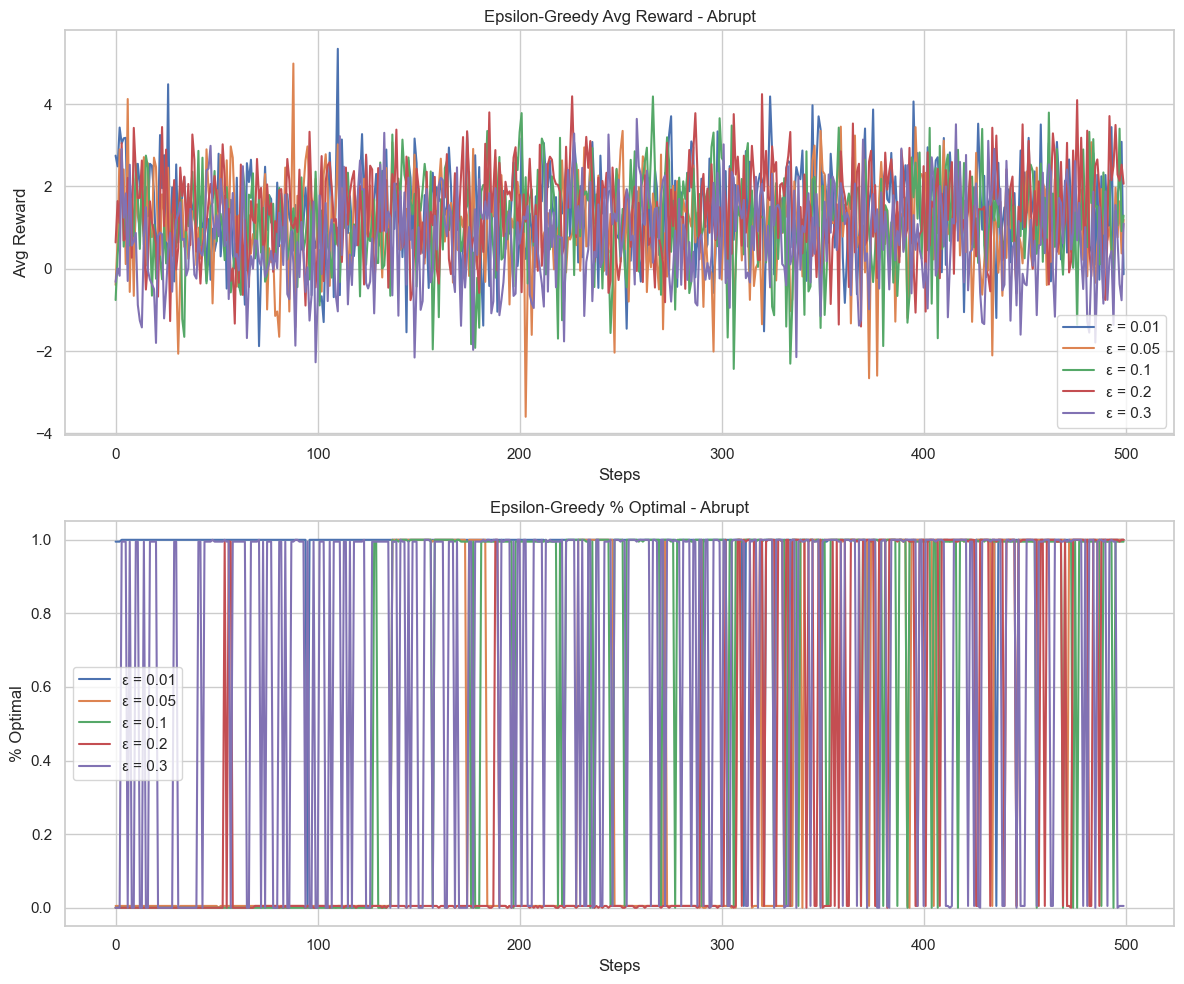

Running pilot study for gradient bandit...
=== Avg Reward per α (Drift Environment) ===
α = 0.01 -> Overall Avg = 0.2832, Last 50 Avg = 0.6038
α = 0.05 -> Overall Avg = 0.9791, Last 50 Avg = 1.3897
α = 0.10 -> Overall Avg = 1.2588, Last 50 Avg = 1.5245
α = 0.20 -> Overall Avg = 1.2724, Last 50 Avg = 1.4276

=== % Optimal Action per α (Drift Environment) ===
α = 0.01 -> Overall Optimal = 15.99%, Last 50 = 23.64%
α = 0.05 -> Overall Optimal = 49.41%, Last 50 = 74.33%
α = 0.10 -> Overall Optimal = 63.31%, Last 50 = 79.56%
α = 0.20 -> Overall Optimal = 69.42%, Last 50 = 81.06%


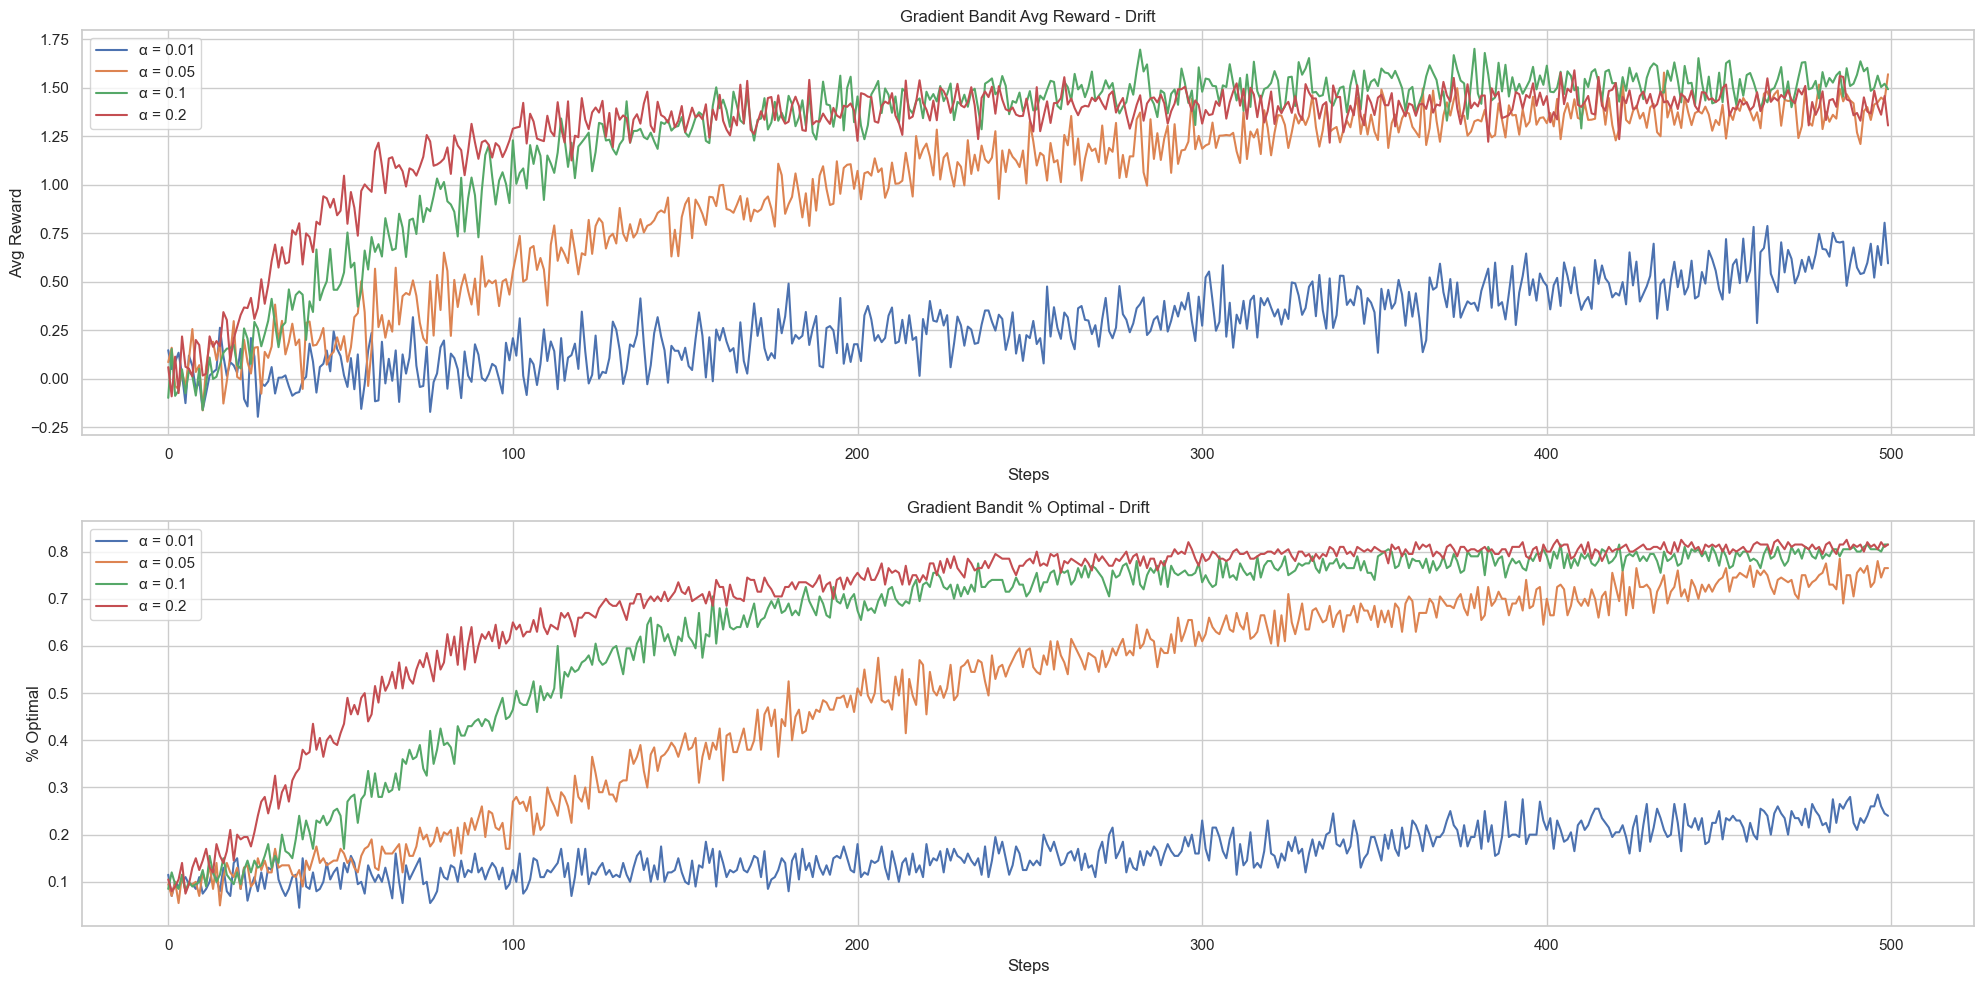

=== Avg Reward per α (Mean Environment) ===
α = 0.01 -> Overall Avg = 0.2828, Last 50 Avg = 0.5415
α = 0.05 -> Overall Avg = 1.0053, Last 50 Avg = 1.4532
α = 0.10 -> Overall Avg = 1.2348, Last 50 Avg = 1.4934
α = 0.20 -> Overall Avg = 1.3791, Last 50 Avg = 1.5488

=== % Optimal Action per α (Mean Environment) ===
α = 0.01 -> Overall Optimal = 16.48%, Last 50 = 25.04%
α = 0.05 -> Overall Optimal = 51.39%, Last 50 = 77.46%
α = 0.10 -> Overall Optimal = 59.62%, Last 50 = 76.31%
α = 0.20 -> Overall Optimal = 66.34%, Last 50 = 77.98%


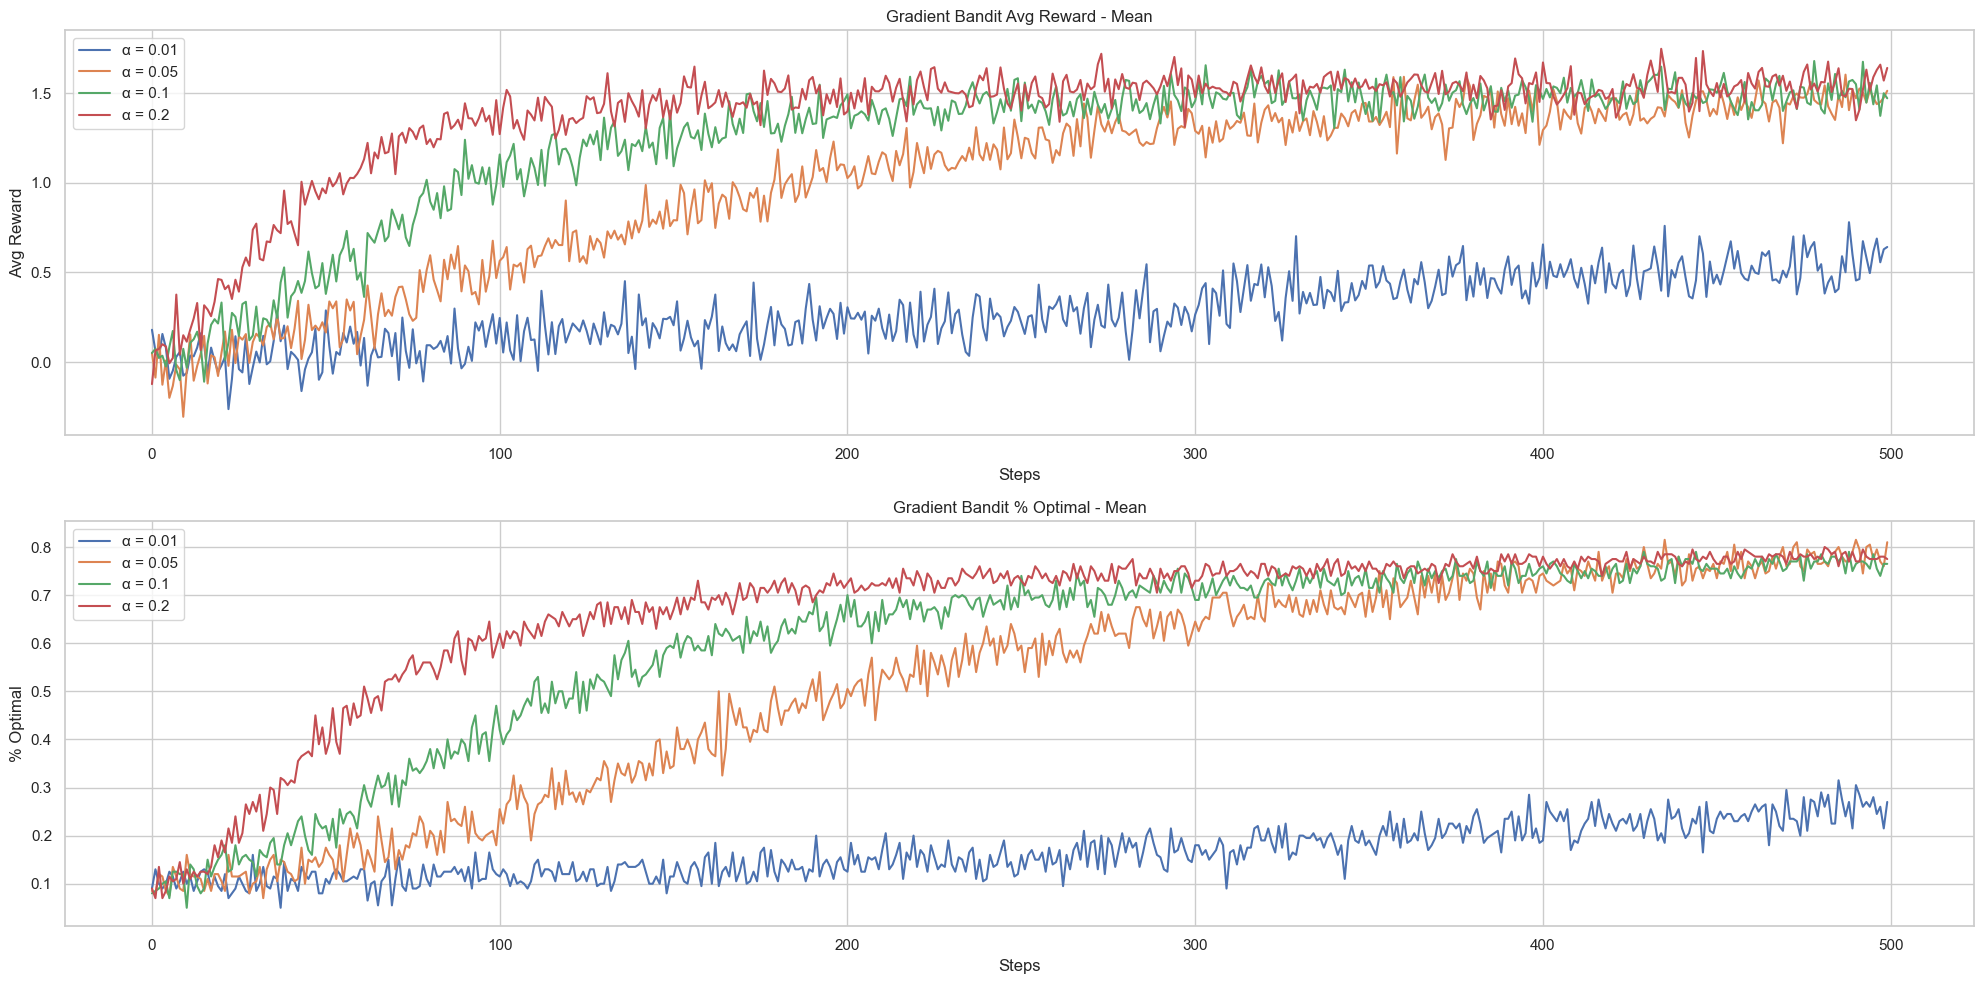

=== Avg Reward per α (Abrupt Environment) ===
α = 0.01 -> Overall Avg = -0.1185, Last 50 Avg = 0.1026
α = 0.05 -> Overall Avg = 0.3994, Last 50 Avg = 0.6964
α = 0.10 -> Overall Avg = 0.6016, Last 50 Avg = 0.8782
α = 0.20 -> Overall Avg = 0.7132, Last 50 Avg = 0.9104

=== % Optimal Action per α (Abrupt Environment) ===
α = 0.01 -> Overall Optimal = 10.40%, Last 50 = 14.00%
α = 0.05 -> Overall Optimal = 38.40%, Last 50 = 74.00%
α = 0.10 -> Overall Optimal = 62.00%, Last 50 = 90.00%
α = 0.20 -> Overall Optimal = 79.40%, Last 50 = 100.00%


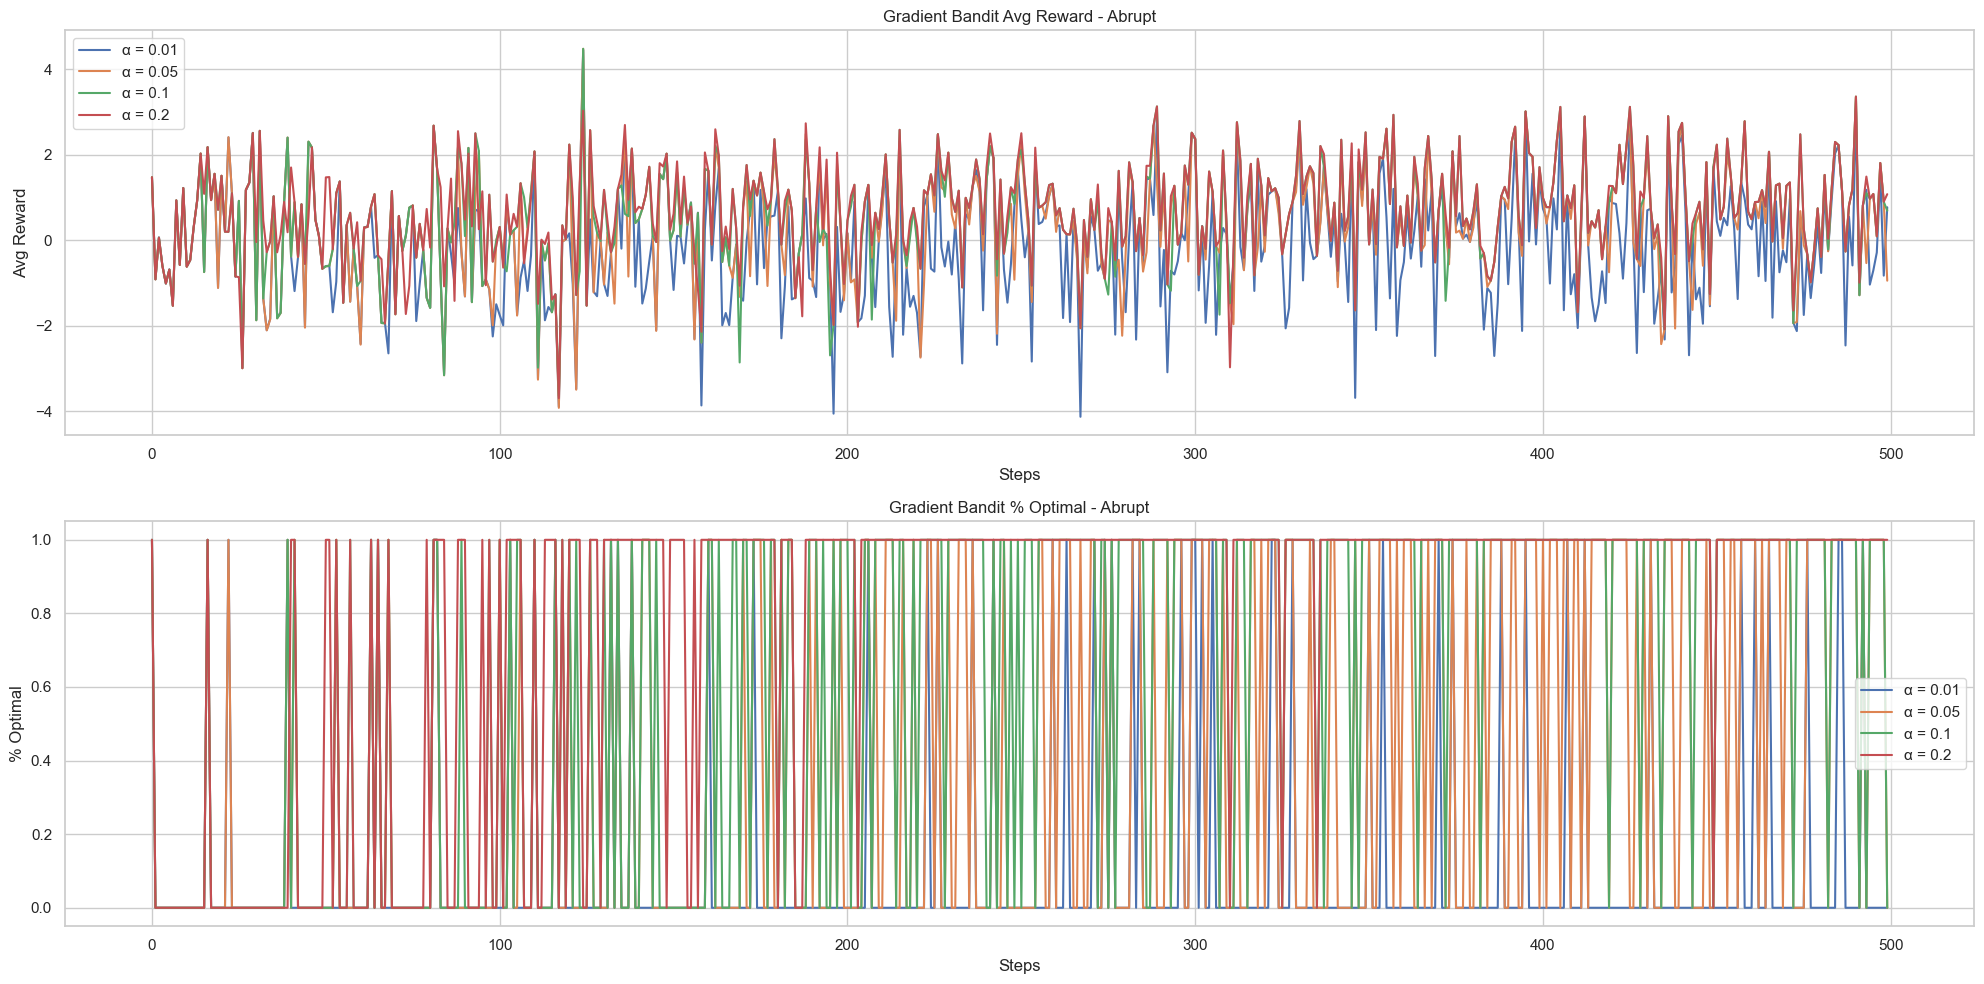

In [24]:
print("Running pilot study for epsilon-greedy...")
pilot_epsilon_nonstationary("drift")
pilot_epsilon_nonstationary("mean")
pilot_epsilon_nonstationary("abrupt")

print("Running pilot study for gradient bandit...")
pilot_gradient_nonstationary("drift")
pilot_gradient_nonstationary("mean")
pilot_gradient_nonstationary("abrupt")

In [29]:
from tqdm import tqdm

In [39]:
 # Find the highest mean arm across all runs
max_mu = np.max(true_means_all, axis=1).max()
# 99.5th percentile of N(μ_max, 1)
optimistic_init = np.percentile(np.random.normal(loc=max_mu, scale=1, size=100000), 99.5)
op_value = optimistic_init

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.38it/s]


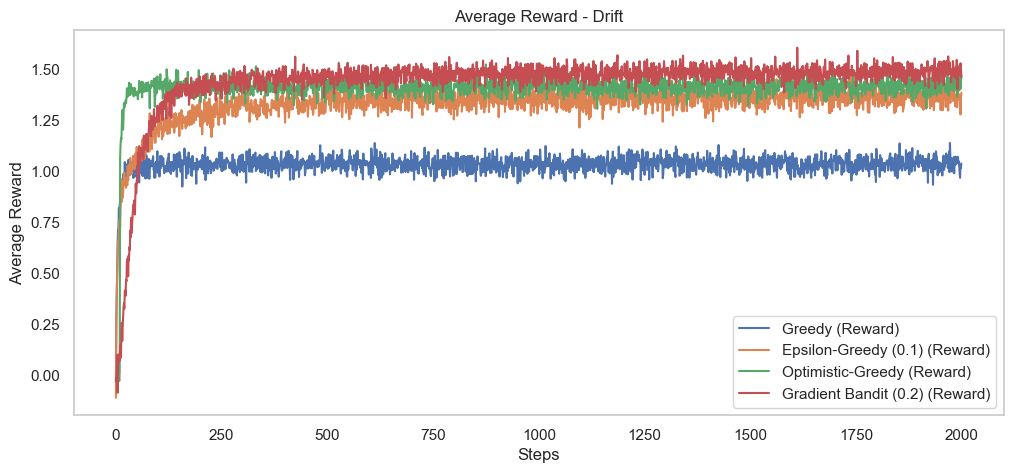

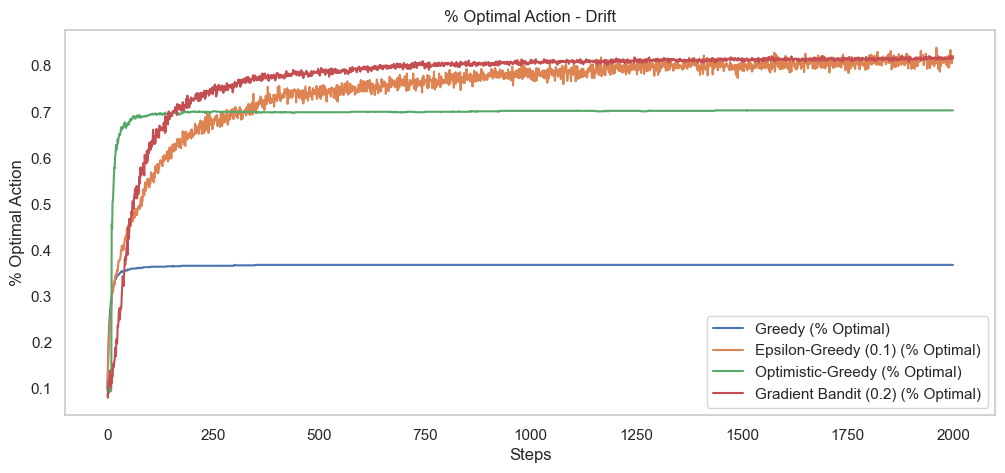

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.82it/s]


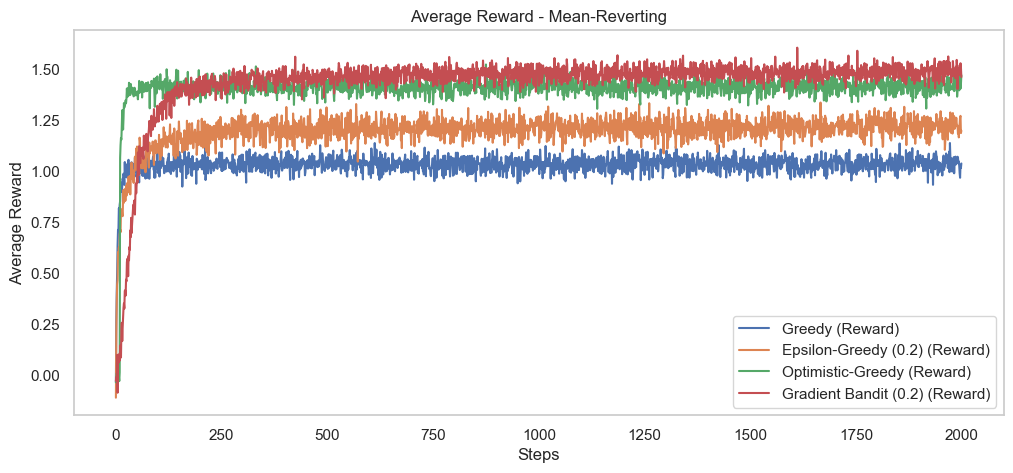

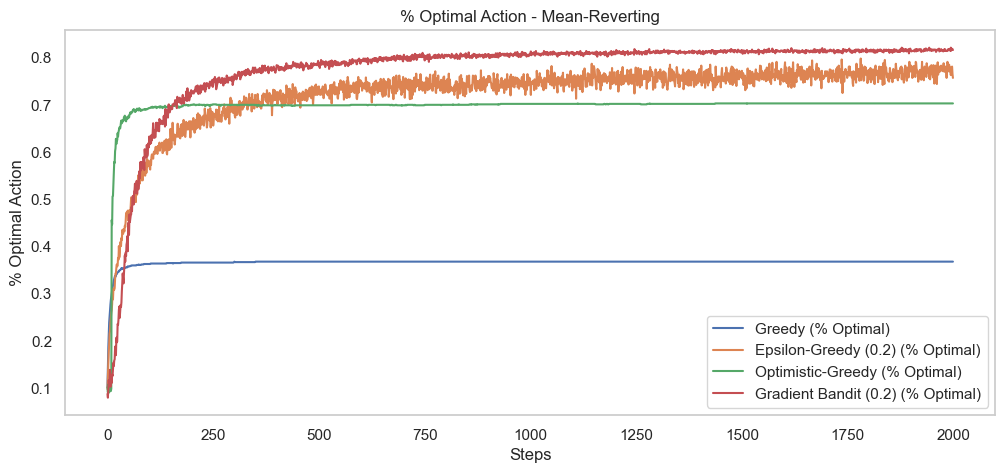

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.39it/s]


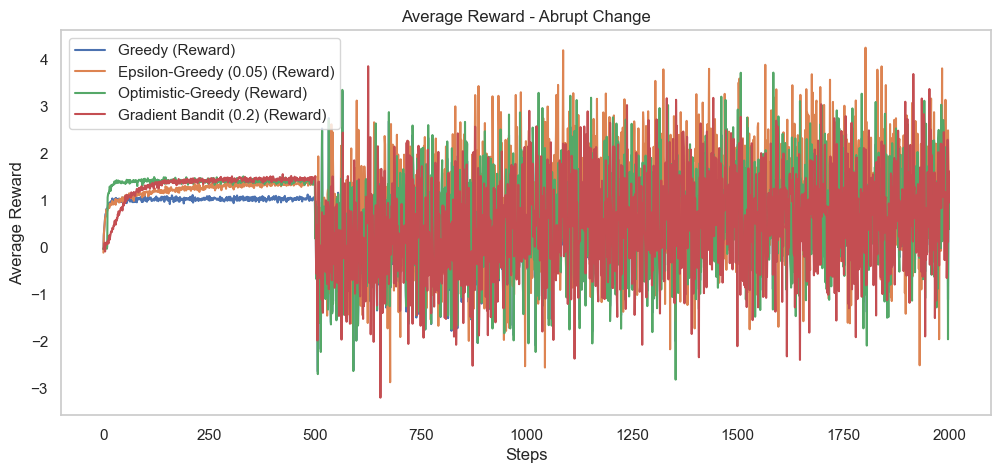

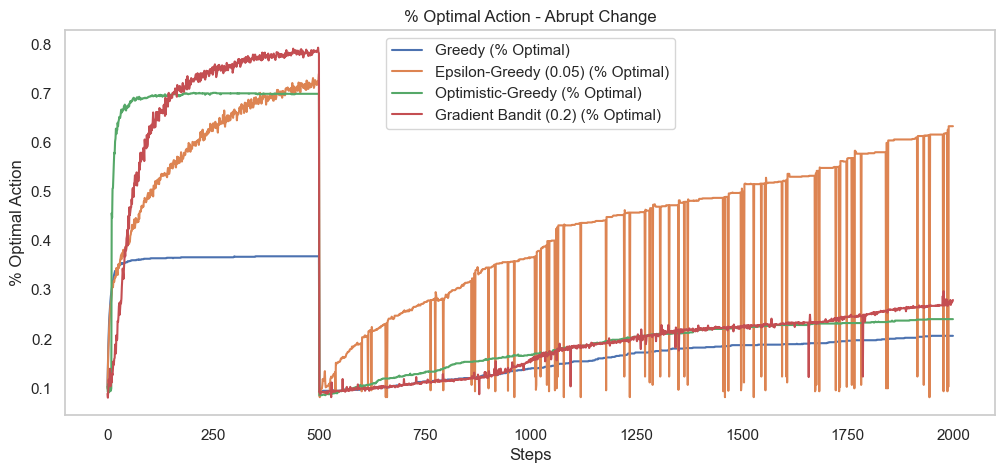

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.05it/s]


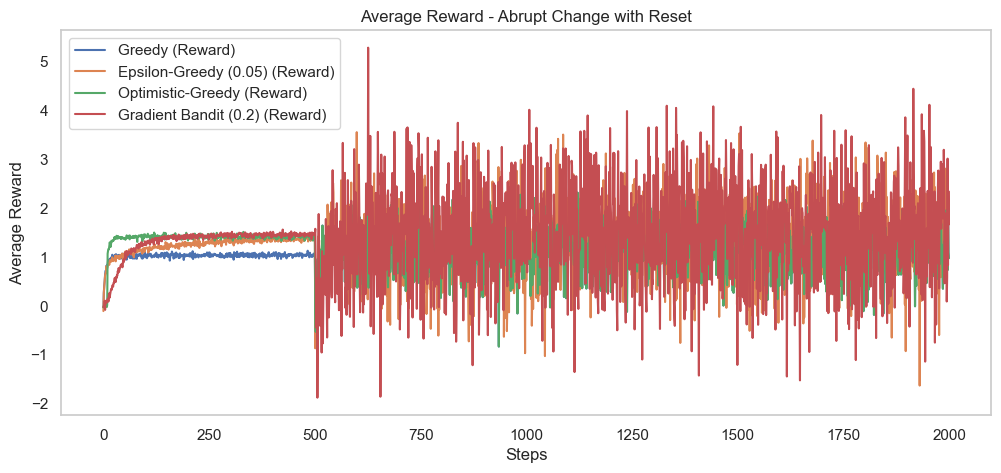

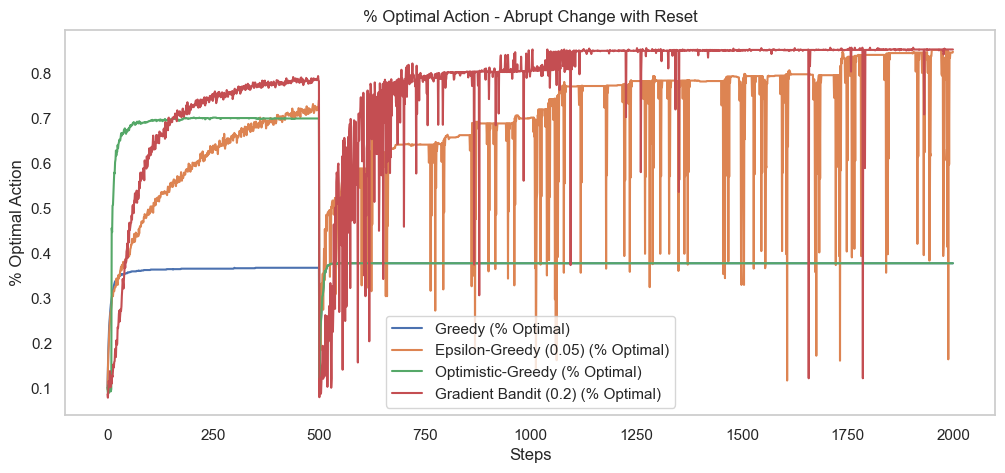

In [40]:
# Simulations
results_drift = {
    "Greedy": simulate("greedy"),
    "Epsilon-Greedy (0.1)": simulate("epsilon-greedy", epsilon=0.1),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2)
}
plot_results(results_drift, "Drift")

results_mean = {
    "Greedy": simulate("greedy", mean_revert=True),
    "Epsilon-Greedy (0.2)": simulate("epsilon-greedy", epsilon=0.2, mean_revert=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, mean_revert=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, mean_revert=True)
}
plot_results(results_mean, "Mean-Reverting")

results_abrupt = {
    "Greedy": simulate("greedy", abrupt=True),
    "Epsilon-Greedy (0.05)": simulate("epsilon-greedy", epsilon=0.05, abrupt=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, abrupt=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, abrupt=True)
}
plot_results(results_abrupt, "Abrupt Change")

results_abrupt_reset = {
    "Greedy": simulate("greedy", abrupt=True, reset=True),
    "Epsilon-Greedy (0.05)": simulate("epsilon-greedy", epsilon=0.05, abrupt=True, reset=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, abrupt=True, reset=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, abrupt=True, reset=True)
}
plot_results(results_abrupt_reset, "Abrupt Change with Reset")